In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import os
from collections import defaultdict
from scipy.spatial import Delaunay

In [2]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator
from biograph import hmrf_em

import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func
from graphsonchip.graphplotter import graph_plot

In [3]:
import coloriage

# Create graph

In [4]:
example_prop_frame = pandas.read_csv('210311_6_cut_seg_cell_type.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color', 'x', 'y', 'z']
n_colors = len(loc.cell_type.unique())

In [5]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [6]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [7]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:    
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

In [8]:
Ginit = G.copy()

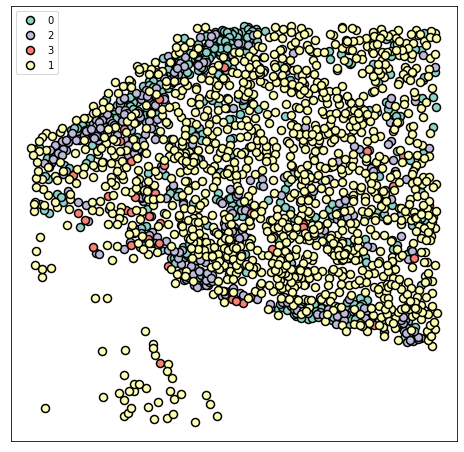

In [9]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [10]:
from coloriage import coloriage

coloriage.make_interactive_plot(G)

Loading BokehJS ...

In [9]:
def categorical_vector(G, category):
    
    cat = nx.get_node_attributes(G, category)
    type_of_data = type(cat[min(cat)])
    V = np.array(list(cat.items()), dtype=type_of_data)
    a = map(int, V[:,0])
    a = np.array(list(a))
    ind = np.argsort(a)
    Vect = V[:,1][ind]
    
    return Vect

# Interactive plot

In [10]:
from random import random

from bokeh.io import output_notebook  # prevent opening separate tab with graph
from bokeh.io import show

from bokeh.layouts import row
from bokeh.layouts import grid
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models import Button  # for saving data
from bokeh.events import ButtonClick  # for saving data
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.models import HoverTool
from bokeh.plotting import figure

In [17]:
def make_interactive_plot(G,
                          plot_width = 400,
                          plot_height = 400):

    # select data
    x = list(categorical_vector(G, 'x'))
    y = list(categorical_vector(G, 'y'))
    cellLabels = list(categorical_vector(G, 'label'))

    # create first subplot
    s1 = ColumnDataSource(data=dict(x=x, 
                                    y=y, 
                                    label = cellLabels))
    fig01 = figure(
        plot_width=plot_width,
        plot_height=plot_height,
        tools=["lasso_select", "reset", "save"],
        title="Select Here",
    )
    fig01.circle("x", "y", alpha=0.8, source=s1)

    # create second subplot
    s2 = ColumnDataSource(data=dict(x=[], y=[]))

    # demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
    fig02 = figure(
        plot_width=plot_width,
        plot_height=plot_height,
        tools=["box_zoom", "wheel_zoom", "reset", "save"],
        title="Watch Here",
    )

    fig02.circle("x", "y", source=s2, alpha=0.6, color= "firebrick")

    # create dynamic table of selected points
    columns = [
        TableColumn(field="x", title="X"),
        TableColumn(field="y", title="Y"),
        TableColumn(field="label", title="Label")
    ]

    table = DataTable(
        source=s2,
        columns=columns,
        width=400,
        height=400,
        sortable=True,
        selectable=True,
        editable=True,
    )

    # fancy javascript to link subplots
    # js pushes selected points into ColumnDataSource of 2nd plot
    # inspiration for this from a few sources:
    # credit: https://stackoverflow.com/users/1097752/iolsmit via: https://stackoverflow.com/questions/48982260/bokeh-lasso-select-to-table-update
    # credit: https://stackoverflow.com/users/8412027/joris via: https://stackoverflow.com/questions/34164587/get-selected-data-contained-within-box-select-tool-in-bokeh

    s1.selected.js_on_change(
        "indices",
        CustomJS(
            args=dict(s1=s1, s2=s2, table=table),
            code="""
            var inds = cb_obj.indices;
            var d1 = s1.data;
            var d2 = s2.data;
            d2['x'] = []
            d2['y'] = []
            d2['label'] = []
            for (var i = 0; i < inds.length; i++) {
                d2['x'].push(d1['x'][inds[i]])
                d2['y'].push(d1['y'][inds[i]])
                d2['label'].push(d1['label'][inds[i]])
            }
            s2.change.emit();
            table.change.emit();

            var inds = source_data.selected.indices;
            var data = source_data.data;
            var out = "x, y\\n";
            for (i = 0; i < inds.length; i++) {
                out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
            }
            var file = new Blob([out], {type: 'text/plain'});
        """,
        ),
    )

    # create save button - saves selected datapoints to text file onbutton
    # inspriation for this code:
    # credit:  https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
    # note: savebutton line `var out = "x, y\\n";` defines the header of the exported file, helpful to have a header for downstream processing

    savebutton = Button(label="Save", button_type="success")
    savebutton.js_on_event(ButtonClick, CustomJS(
        args=dict(source_data=s1),
        code="""
            var inds = source_data.selected.indices;
            var data = source_data.data;
            var out = "x, y, z, cell_type, cell_label\\n";
            for (var i = 0; i < inds.length; i++) {
                out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "," + data['z'][inds[i]] + "," + data['celltyp'][inds[i]] + "\\n";
            }
            var file = new Blob([out], {type: 'text/plain'});

        var elem = window.document.createElement('a');
        elem.href = window.URL.createObjectURL(file);
            elem.download = 'selected-data.txt';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """
            )
                             )

    # add Hover tool
    # define what is displayed in the tooltip
    tooltips = [
        ("X:", "@x"),
        ("Y:", "@y"),
        ("type:", "@celltyp"),
    #    ("static text", "static text"),
    ]

    #fig01.add_tools(HoverTool(tooltips=tooltips))
    fig02.add_tools(HoverTool(tooltips=tooltips))

    # display results
    # demo linked plots
    # demo zooms and reset
    # demo hover tool
    # demo table
    # demo save selected results to file

    #layout = grid([fig01, table, savebutton], ncols=3)
    layout = grid([fig01, fig02, table, savebutton], ncols=4)

    output_notebook()
    show(layout)
    
    return

In [18]:
make_interactive_plot(G)

Loading BokehJS ...

In [16]:
# select data
x = list(categorical_vector(G, 'x'))
y = list(categorical_vector(G, 'y'))
cellLabels = list(categorical_vector(G, 'label'))

# create first subplot
s1 = ColumnDataSource(data=dict(x=x, 
                                y=y, 
                                label = cellLabels))
fig01 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["lasso_select", "reset", "save"],
    title="Select Here",
)
fig01.circle("x", "y", alpha=0.8, source=s1)

# create second subplot
s2 = ColumnDataSource(data=dict(x=[], y=[]))

# demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
fig02 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="Watch Here",
)

fig02.circle("x", "y", source=s2, alpha=0.6, color= "firebrick")

# create dynamic table of selected points
columns = [
    TableColumn(field="x", title="X"),
    TableColumn(field="y", title="Y"),
    TableColumn(field="label", title="Label")
]

table = DataTable(
    source=s2,
    columns=columns,
    width=400,
    height=400,
    sortable=True,
    selectable=True,
    editable=True,
)

# fancy javascript to link subplots
# js pushes selected points into ColumnDataSource of 2nd plot
# inspiration for this from a few sources:
# credit: https://stackoverflow.com/users/1097752/iolsmit via: https://stackoverflow.com/questions/48982260/bokeh-lasso-select-to-table-update
# credit: https://stackoverflow.com/users/8412027/joris via: https://stackoverflow.com/questions/34164587/get-selected-data-contained-within-box-select-tool-in-bokeh

s1.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=s1, s2=s2, table=table),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        d2['label'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
            d2['label'].push(d1['label'][inds[i]])
        }
        s2.change.emit();
        table.change.emit();
        
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y\\n";
        for (i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});
    """,
    ),
)

# create save button - saves selected datapoints to text file onbutton
# inspriation for this code:
# credit:  https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
# note: savebutton line `var out = "x, y\\n";` defines the header of the exported file, helpful to have a header for downstream processing

savebutton = Button(label="Save", button_type="success")
savebutton.js_on_event(ButtonClick, CustomJS(
    args=dict(source_data=s1),
    code="""
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y, z, cell_type, cell_label\\n";
        for (var i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "," + data['z'][inds[i]] + "," + data['celltyp'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});

    var elem = window.document.createElement('a');
    elem.href = window.URL.createObjectURL(file);
        elem.download = 'selected-data.txt';
        document.body.appendChild(elem);
        elem.click();
        document.body.removeChild(elem);
        """
        )
                         )

# add Hover tool
# define what is displayed in the tooltip
tooltips = [
    ("X:", "@x"),
    ("Y:", "@y"),
    ("type:", "@celltyp"),
#    ("static text", "static text"),
]

#fig01.add_tools(HoverTool(tooltips=tooltips))
fig02.add_tools(HoverTool(tooltips=tooltips))

# display results
# demo linked plots
# demo zooms and reset
# demo hover tool
# demo table
# demo save selected results to file

#layout = grid([fig01, table, savebutton], ncols=3)
layout = grid([fig01, fig02, table, savebutton], ncols=4)

output_notebook()
show(layout)

Loading BokehJS ...

In [14]:
# select data
x = list(categorical_vector(G, 'x'))
y = list(categorical_vector(G, 'y'))
z = list(categorical_vector(G, 'z'))
cellTypes = list(categorical_vector(G, 'cell_type'))
cellLabels = list(categorical_vector(G, 'label'))
#colorGraph = categorical_vector(G, 'color')
colorGraph = plt.cm.Set3(cellTypes)

# create first subplot
plot_width = 400
plot_height = 400

s1 = ColumnDataSource(data=dict(x=x, 
                                y=y, 
                                z=z, 
                                celltyp = cellTypes, 
                                col = colorGraph,
                                label = cellLabels))
fig01 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["lasso_select", "reset", "save"],
    title="Select Here",
)
fig01.circle("x", "y", alpha=0.8, color = "col", source=s1)

# create second subplot
s2 = ColumnDataSource(data=dict(x=[], y=[]))

# demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
fig02 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="Watch Here",
)

fig02.circle("x", "y", source=s2, alpha=0.6, color= "firebrick")

# create dynamic table of selected points
columns = [
    TableColumn(field="x", title="X"),
    TableColumn(field="y", title="Y"),
    TableColumn(field="z", title="Z"),
    TableColumn(field="celltyp", title="Cell type"),
    TableColumn(field="label", title="Label")
]

table = DataTable(
    source=s2,
    columns=columns,
    width=400,
    height=400,
    sortable=True,
    selectable=True,
    editable=True,
)

# fancy javascript to link subplots
# js pushes selected points into ColumnDataSource of 2nd plot
# inspiration for this from a few sources:
# credit: https://stackoverflow.com/users/1097752/iolsmit via: https://stackoverflow.com/questions/48982260/bokeh-lasso-select-to-table-update
# credit: https://stackoverflow.com/users/8412027/joris via: https://stackoverflow.com/questions/34164587/get-selected-data-contained-within-box-select-tool-in-bokeh

s1.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=s1, s2=s2, table=table),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        d2['z'] = []
        d2['celltyp'] = []
        d2['label'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
            d2['z'].push(d1['z'][inds[i]])
            d2['celltyp'].push(d1['celltyp'][inds[i]])
            d2['label'].push(d1['label'][inds[i]])
        }
        s2.change.emit();
        table.change.emit();
        
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y\\n";
        for (i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});
    """,
    ),
)

# create save button - saves selected datapoints to text file onbutton
# inspriation for this code:
# credit:  https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
# note: savebutton line `var out = "x, y\\n";` defines the header of the exported file, helpful to have a header for downstream processing

savebutton = Button(label="Save", button_type="success")
savebutton.js_on_event(ButtonClick, CustomJS(
    args=dict(source_data=s1),
    code="""
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y, z, cell_type, cell_label\\n";
        for (var i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "," + data['z'][inds[i]] + "," + data['celltyp'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});

    var elem = window.document.createElement('a');
    elem.href = window.URL.createObjectURL(file);
        elem.download = 'selected-data.txt';
        document.body.appendChild(elem);
        elem.click();
        document.body.removeChild(elem);
        """
        )
                         )

# add Hover tool
# define what is displayed in the tooltip
tooltips = [
    ("X:", "@x"),
    ("Y:", "@y"),
    ("type:", "@celltyp"),
#    ("static text", "static text"),
]

#fig01.add_tools(HoverTool(tooltips=tooltips))
fig02.add_tools(HoverTool(tooltips=tooltips))

# display results
# demo linked plots
# demo zooms and reset
# demo hover tool
# demo table
# demo save selected results to file

#layout = grid([fig01, table, savebutton], ncols=3)
layout = grid([fig01, fig02, table, savebutton], ncols=4)

output_notebook()
show(layout)

Loading BokehJS ...

# Change cell types for selected cells

This can be done several times if we select different areas. In that case, you just need to runs the following cells for each .txt file

In [15]:
# Read selected data
#SelectedData = pandas.read_csv('Edge_1_test.txt')
SelectedData = pandas.read_csv('Edge_2_test.txt')
SelectedData = np.array(SelectedData)
SelectedData = pandas.DataFrame(SelectedData, columns = ['x', 'y', 'z', 'cell_type', 'cell_label'])

In [16]:
# Select corresponding nodes in the graph
def extracts_nodes(G, SelectedData):
    X = categorical_vector(G, 'x')
    X = X.astype(int)
    Y = categorical_vector(G, 'y')
    Y = Y.astype(int)
    Z = categorical_vector(G, 'z')
    Z = Z.astype(int)

    selectedX = np.array(SelectedData['x'])
    selectedY = np.array(SelectedData['y'])
    selectedZ = np.array(SelectedData['z'])
    
    pos = np.array([X, Y, Z]).T
    selectedpos = np.array([selectedX, selectedY, selectedZ]).T
    
    Nodes = []
    for l in selectedpos:
        s = np.where((pos[:, 0] == l[0]) & (pos[:, 1] == l[1]) & (pos[:, 2] == l[2]))[0][0]
        Nodes.append(s)
        
    return Nodes

In [17]:
Nodes = extracts_nodes(G, SelectedData) # Nodes in selected Data

In [18]:
# Add new types for the selected data
Ntypes = max(categorical_vector(G, 'cell_type')) # Number of cell types in the original graph
Types_subGraph = np.unique(categorical_vector(G.subgraph(Nodes), 'cell_type')) # List of cell types in subgraph

color_list = [plt.cm.Set3(i) for i in range(Ntypes + len(Types_subGraph))] # list of colors with new types

cell_types = nx.get_node_attributes(G, 'cell_type')
for node in Nodes:
    ind = np.where(Types_subGraph == cell_types[node])[0][0] # index of type
    new_type = ind + Ntypes
    nx.set_node_attributes(G, {node:new_type}, 'cell_type')
    nx.set_node_attributes(G, {node:color_list[new_type]}, 'color')
    nx.set_node_attributes(G, {node:new_type}, 'legend')

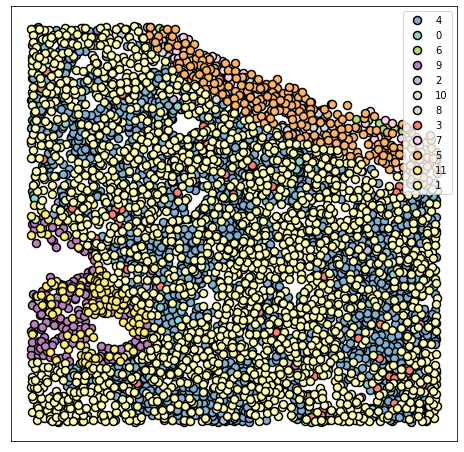

In [19]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

# Run HMRF on the manually modified graph

In [20]:
K = 6
beta = 20
max_it = 20
model = hmrf_em.hmrf(G, K, beta, max_it)

In [21]:
model.initiate_model()

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 29235.44it/s]


In [22]:
model.run()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.85s/it]


<Figure size 432x288 with 0 Axes>

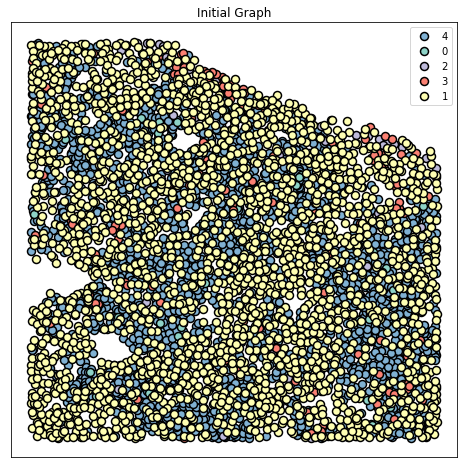

<Figure size 432x288 with 0 Axes>

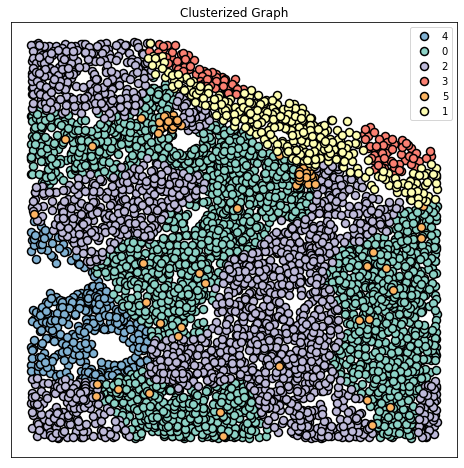

In [23]:
plt.figure()
graphplot.scatter_plot_2D(Ginit, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Initial Graph')
plt.show()

plt.figure()
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))
plt.title('Clusterized Graph')
plt.show()